# Simple FFN - Feed Forward Neural Network

In [1]:
import numpy as np
import os
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from PIL import Image
import matplotlib.pyplot as plt

#### Utilitiy Functions - Dataset Loader Function and other functions

In [2]:
def load_train_data(base_path, img_size=(32, 32)):
    class_folders = sorted(os.listdir(base_path))
    images = []
    labels = []
    for class_name in class_folders:
        class_path = os.path.join(base_path, class_name)
        if not os.path.isdir(class_path):
            continue
        for img_name in os.listdir(class_path):
            img_path = os.path.join(class_path, img_name)
            try:
                img = Image.open(img_path).convert('RGB')
                img = img.resize(img_size)
                img_array = np.asarray(img).flatten()
                images.append(img_array)
                labels.append(int(class_name))
            except Exception as e:
                print(f"Error loading image {img_path}: {e}")
    X = np.array(images) / 255.0
    y = np.array(labels)
    lb = LabelBinarizer()
    y = lb.fit_transform(y)
    return X, y

#### Train - Test - Val Split

In [3]:
def split_train_val(X, y, val_size=0.2):
    return train_test_split(X, y, test_size=val_size, random_state=42)

#### Plotting the results

In [4]:
def plot_curves(train_acc, val_acc, train_loss, val_loss, title='ImprovedFFN'):
    epochs = np.arange(1, len(train_acc)+1)
    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    plt.plot(epochs, train_acc, label='Train Acc')
    plt.plot(epochs, val_acc, label='Val Acc')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title(f'{title} Accuracy')
    plt.legend()
    plt.subplot(1,2,2)
    plt.plot(epochs, train_loss, label='Train Loss')
    plt.plot(epochs, val_loss, label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(f'{title} Loss')
    plt.legend()
    plt.tight_layout()
    plt.show()

#  SimpleFFN Model

In [6]:
class SimpleFFN:
    def __init__(self, input_size, hidden_sizes, output_size, learning_rate=0.01, dropout_rate=0.2):
        self.lr = learning_rate
        self.dropout_rate = dropout_rate
        self.input_size = input_size
        self.hidden1_size = hidden_sizes[0]
        self.hidden2_size = hidden_sizes[1]
        self.output_size = output_size
        self.W1 = np.random.randn(input_size, self.hidden1_size) * np.sqrt(2. / input_size)
        self.b1 = np.zeros((1, self.hidden1_size))
        self.W2 = np.random.randn(self.hidden1_size, self.hidden2_size) * np.sqrt(2. / self.hidden1_size)
        self.b2 = np.zeros((1, self.hidden2_size))
        self.W3 = np.random.randn(self.hidden2_size, output_size) * np.sqrt(2. / self.hidden2_size)
        self.b3 = np.zeros((1, output_size))

    def relu(self, z):
        return np.maximum(0, z)

    def relu_derivative(self, z):
        return (z > 0).astype(float)

    def softmax(self, z):
        exp_z = np.exp(z - np.max(z, axis=1, keepdims=True))
        return exp_z / np.sum(exp_z, axis=1, keepdims=True)

    def cross_entropy_loss(self, y_pred, y_true):
        m = y_true.shape[0]
        loss = -np.sum(y_true * np.log(y_pred + 1e-9)) / m
        return loss

    def accuracy(self, y_pred, y_true):
        preds = np.argmax(y_pred, axis=1)
        labels = np.argmax(y_true, axis=1)
        return np.mean(preds == labels)

    def forward(self, X, training=True):
        self.Z1 = np.dot(X, self.W1) + self.b1
        self.A1 = self.relu(self.Z1)
        if training:
            self.dropout_mask1 = (np.random.rand(*self.A1.shape) > self.dropout_rate).astype(float)
            self.A1 *= self.dropout_mask1
            self.A1 /= (1.0 - self.dropout_rate)
        else:
            self.dropout_mask1 = 1.0
        self.Z2 = np.dot(self.A1, self.W2) + self.b2
        self.A2 = self.relu(self.Z2)
        if training:
            self.dropout_mask2 = (np.random.rand(*self.A2.shape) > self.dropout_rate).astype(float)
            self.A2 *= self.dropout_mask2
            self.A2 /= (1.0 - self.dropout_rate)
        else:
            self.dropout_mask2 = 1.0
        self.Z3 = np.dot(self.A2, self.W3) + self.b3
        self.A3 = self.softmax(self.Z3)
        return self.A3

    def backward(self, X, y_true, y_pred):
        m = X.shape[0]
        dZ3 = y_pred - y_true
        dW3 = np.dot(self.A2.T, dZ3) / m
        db3 = np.sum(dZ3, axis=0, keepdims=True) / m
        dA2 = np.dot(dZ3, self.W3.T)
        dA2 *= self.dropout_mask2
        dZ2 = dA2 * self.relu_derivative(self.Z2)
        dW2 = np.dot(self.A1.T, dZ2) / m
        db2 = np.sum(dZ2, axis=0, keepdims=True) / m
        dA1 = np.dot(dZ2, self.W2.T)
        dA1 *= self.dropout_mask1
        dZ1 = dA1 * self.relu_derivative(self.Z1)
        dW1 = np.dot(X.T, dZ1) / m
        db1 = np.sum(dZ1, axis=0, keepdims=True) / m
        self.W3 -= self.lr * dW3
        self.b3 -= self.lr * db3
        self.W2 -= self.lr * dW2
        self.b2 -= self.lr * db2
        self.W1 -= self.lr * dW1
        self.b1 -= self.lr * db1


#### Training the model

In [7]:
def train(self, X, y, X_val, y_val, epochs=35, batch_size=64):
        train_accs, val_accs, train_losses, val_losses = [], [], [], []
        for epoch in range(epochs):
            indices = np.arange(X.shape[0])
            np.random.shuffle(indices)
            X = X[indices]
            y = y[indices]
            for i in range(0, X.shape[0], batch_size):
                X_batch = X[i:i+batch_size]
                y_batch = y[i:i+batch_size]
                y_pred = self.forward(X_batch, training=True)
                self.backward(X_batch, y_batch, y_pred)
            train_pred = self.forward(X, training=False)
            val_pred = self.forward(X_val, training=False)
            train_loss = self.cross_entropy_loss(train_pred, y)
            val_loss = self.cross_entropy_loss(val_pred, y_val)
            train_acc = self.accuracy(train_pred, y)
            val_acc = self.accuracy(val_pred, y_val)
            train_accs.append(train_acc)
            val_accs.append(val_acc)
            train_losses.append(train_loss)
            val_losses.append(val_loss)
            print(f"Epoch {epoch+1}/{epochs} - Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")
        return train_accs, val_accs, train_losses, val_losses


#### Hyperparameter Tuning

In [8]:
def tune_simple_ffn(X_train, y_train, X_val, y_val, input_size, output_size):
    best_acc = 0
    best_config = {}
    best_histories = None
    best_model = None
    hidden_combinations = [(256, 128), (128, 64)]
    learning_rates = [0.01, 0.005]
    dropout_rates = [0.3, 0.2]
    batch_size = 64
    epochs = 30
    total = len(hidden_combinations) * len(learning_rates) * len(dropout_rates)
    run = 1
    for hidden_sizes in hidden_combinations:
        for lr in learning_rates:
            for dropout in dropout_rates:
                print(f"\nRun {run}/{total} | h={hidden_sizes}, lr={lr}, dr={dropout}")
                run += 1
                model = ImprovedFFN(input_size, hidden_sizes, output_size,
                                    learning_rate=lr, dropout_rate=dropout)
                train_accs, val_accs, train_losses, val_losses = model.train(
                    X_train, y_train, X_val, y_val, epochs=epochs, batch_size=batch_size
                )
                val_pred = model.forward(X_val, training=False)
                val_acc = model.accuracy(val_pred, y_val)
                if val_acc > best_acc:
                    best_acc = val_acc
                    best_config = {
                        "hidden_sizes": hidden_sizes,
                        "learning_rate": lr,
                        "dropout_rate": dropout,
                        "batch_size": batch_size,
                        "epochs": epochs
                    }
                    best_histories = (train_accs, val_accs, train_losses, val_losses)
                    best_model = model
    print("\nBest Configuration:")
    print(best_config)
    print(f"Best Validation Accuracy: {best_acc:.4f}")
    return best_config, best_histories, best_model

#### Main code


Tuning ImprovedFFN:

Run 1/8 | h=(256, 128), lr=0.01, dr=0.3
Epoch 1/35 - Train Loss: 3.1378, Train Acc: 0.2700, Val Loss: 3.1352, Val Acc: 0.2807
Epoch 2/35 - Train Loss: 2.6522, Train Acc: 0.4041, Val Loss: 2.6591, Val Acc: 0.4049
Epoch 3/35 - Train Loss: 2.2632, Train Acc: 0.4563, Val Loss: 2.2765, Val Acc: 0.4584
Epoch 4/35 - Train Loss: 1.9795, Train Acc: 0.5137, Val Loss: 1.9937, Val Acc: 0.5125
Epoch 5/35 - Train Loss: 1.8211, Train Acc: 0.5236, Val Loss: 1.8445, Val Acc: 0.5260
Epoch 6/35 - Train Loss: 1.5257, Train Acc: 0.6000, Val Loss: 1.5495, Val Acc: 0.5949
Epoch 7/35 - Train Loss: 1.3773, Train Acc: 0.6563, Val Loss: 1.4060, Val Acc: 0.6470
Epoch 8/35 - Train Loss: 1.2307, Train Acc: 0.7019, Val Loss: 1.2540, Val Acc: 0.6937
Epoch 9/35 - Train Loss: 1.1432, Train Acc: 0.7139, Val Loss: 1.1689, Val Acc: 0.7065
Epoch 10/35 - Train Loss: 1.1527, Train Acc: 0.6658, Val Loss: 1.1740, Val Acc: 0.6584
Epoch 11/35 - Train Loss: 1.1604, Train Acc: 0.6975, Val Loss: 1.1854, Val Ac

Epoch 24/35 - Train Loss: 0.8048, Train Acc: 0.8280, Val Loss: 0.8327, Val Acc: 0.8196
Epoch 25/35 - Train Loss: 0.7701, Train Acc: 0.8387, Val Loss: 0.7978, Val Acc: 0.8289
Epoch 26/35 - Train Loss: 0.7825, Train Acc: 0.8196, Val Loss: 0.8092, Val Acc: 0.8091
Epoch 27/35 - Train Loss: 0.7148, Train Acc: 0.8492, Val Loss: 0.7433, Val Acc: 0.8400
Epoch 28/35 - Train Loss: 0.6874, Train Acc: 0.8614, Val Loss: 0.7150, Val Acc: 0.8534
Epoch 29/35 - Train Loss: 0.6733, Train Acc: 0.8627, Val Loss: 0.7004, Val Acc: 0.8539
Epoch 30/35 - Train Loss: 0.6553, Train Acc: 0.8617, Val Loss: 0.6855, Val Acc: 0.8550
Epoch 31/35 - Train Loss: 0.6324, Train Acc: 0.8677, Val Loss: 0.6616, Val Acc: 0.8579
Epoch 32/35 - Train Loss: 0.6100, Train Acc: 0.8687, Val Loss: 0.6395, Val Acc: 0.8597
Epoch 33/35 - Train Loss: 0.5918, Train Acc: 0.8782, Val Loss: 0.6228, Val Acc: 0.8684
Epoch 34/35 - Train Loss: 0.5881, Train Acc: 0.8725, Val Loss: 0.6206, Val Acc: 0.8632
Epoch 35/35 - Train Loss: 0.5531, Train Acc

Epoch 13/35 - Train Loss: 0.7367, Train Acc: 0.8247, Val Loss: 0.7567, Val Acc: 0.8145
Epoch 14/35 - Train Loss: 1.0322, Train Acc: 0.7194, Val Loss: 1.0615, Val Acc: 0.7138
Epoch 15/35 - Train Loss: 0.6532, Train Acc: 0.8484, Val Loss: 0.6803, Val Acc: 0.8429
Epoch 16/35 - Train Loss: 0.6254, Train Acc: 0.8563, Val Loss: 0.6494, Val Acc: 0.8462
Epoch 17/35 - Train Loss: 0.8154, Train Acc: 0.7563, Val Loss: 0.8366, Val Acc: 0.7554
Epoch 18/35 - Train Loss: 0.5797, Train Acc: 0.8623, Val Loss: 0.6007, Val Acc: 0.8521
Epoch 19/35 - Train Loss: 0.5181, Train Acc: 0.8782, Val Loss: 0.5443, Val Acc: 0.8697
Epoch 20/35 - Train Loss: 0.4978, Train Acc: 0.8874, Val Loss: 0.5271, Val Acc: 0.8766
Epoch 21/35 - Train Loss: 0.8684, Train Acc: 0.7358, Val Loss: 0.8847, Val Acc: 0.7367
Epoch 22/35 - Train Loss: 0.5350, Train Acc: 0.8660, Val Loss: 0.5664, Val Acc: 0.8578
Epoch 23/35 - Train Loss: 0.5102, Train Acc: 0.8639, Val Loss: 0.5439, Val Acc: 0.8526
Epoch 24/35 - Train Loss: 0.4492, Train Acc

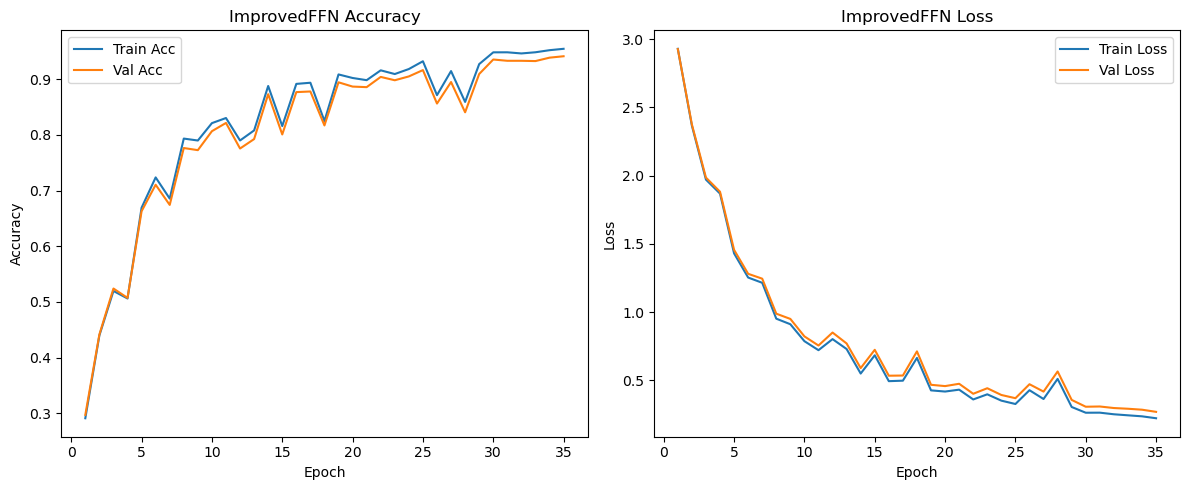

In [7]:
if __name__ == "__main__":
    train_path = "/Users/pavankoushik/Development/University/Neural Networks/Dataset/Train"
    # Load and split train/val
    X, y = load_train_data(train_path)
    X_train, X_val, y_train, y_val = split_train_val(X, y, val_size=0.2)
    print("\nTuning ImprovedFFN:")
    best_config, histories, best_model = tune_improved_ffn(
        X_train, y_train, X_val, y_val, input_size=X_train.shape[1], output_size=y_train.shape[1]
    )
    plot_curves(*histories, title="ImprovedFFN")
